In [2]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "truncnorm", "tidyr", "survival", "nph", "tidyverse",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang", "simtrial", "ggrepel","viridis")
install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
cluster <- makeCluster(16) # How many cores we use
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

# RMST Estimation with censoring in interim 1 year

RMST of Control arm is: 0.495229 
Variance of RMST estimation of Control arm is: 2.732952e-05 
RMST of Experiment arm is: 0.6448322 
Variance of RMST estimation of Experiment arm is: 2.831875e-05

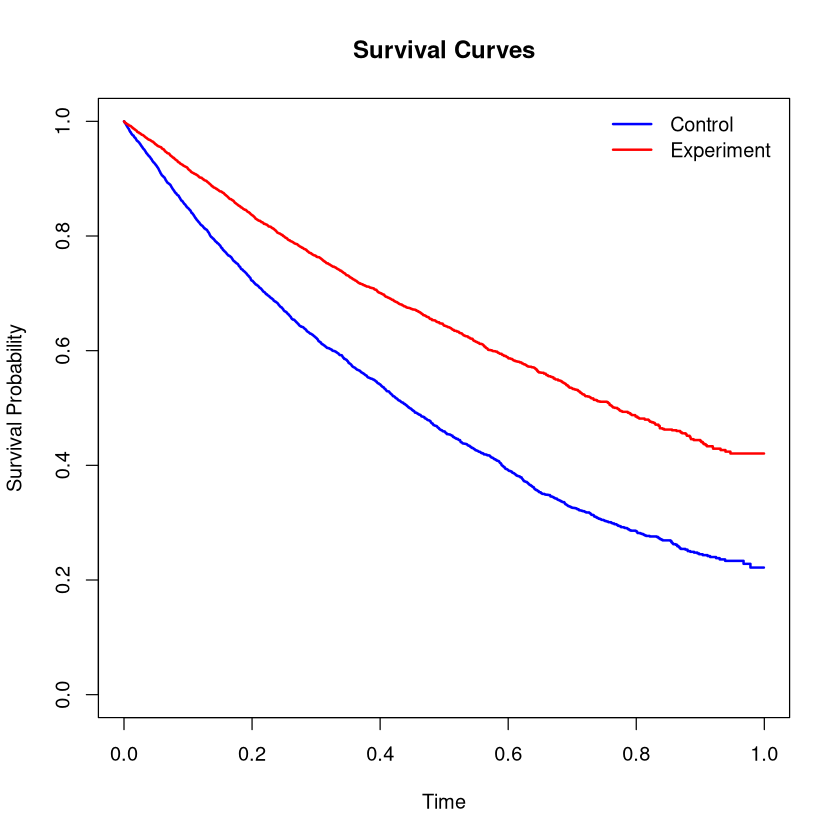

In [36]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(2,3,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(2,3,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_int <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 0.96)

cat('RMST of Control arm is:',rmst_result_int$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_int$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_int$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_int$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

### RMST Estimation with censoring in the whole study

RMST of Control arm is: 0.4923799 
Variance of RMST estimation of Control arm is: 1.212278e-05 
RMST of Experiment arm is: 0.6585054 
Variance of RMST estimation of Experiment arm is: 1.264252e-05

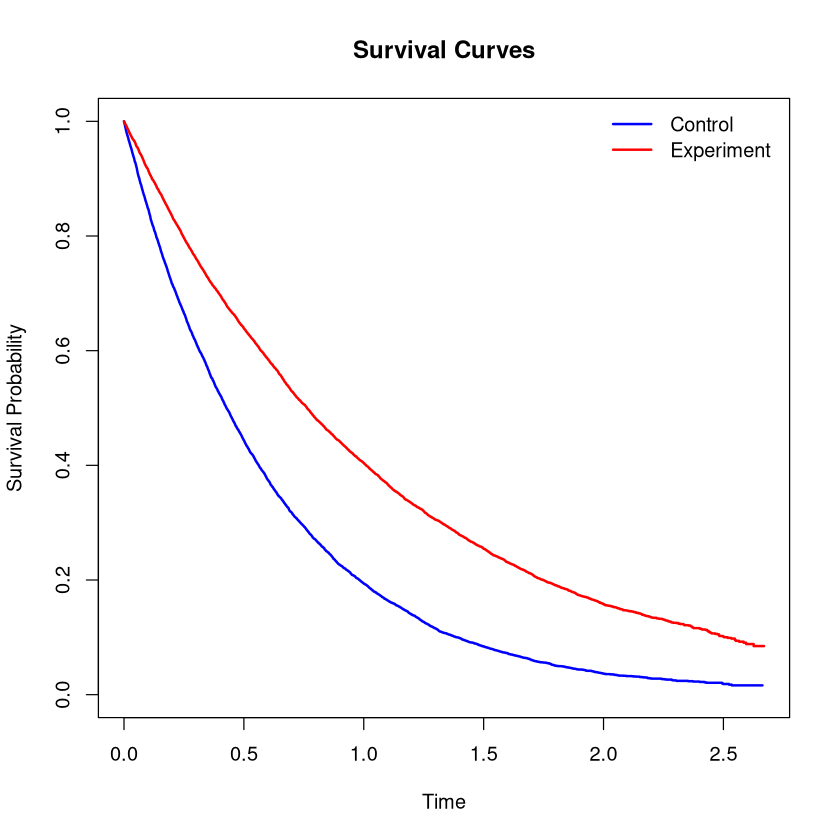

In [37]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(4,5,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(4,5,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_all <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 1)

cat('RMST of Control arm is:',rmst_result_all$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_all$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_all$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_all$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

------

# 2 stages Experiment

#### Setting: acc_time = 1.67, cen_time = 1, interim $\tau_1 = 1$
####  $\textcolor{lightgreen}{H_0 : \lambda_0 = \lambda_1 = 1.609}$    
####  $\textcolor{lightgreen}{H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916}$  
#### α = 0.1, power = 0.9. Sample size = 102 (51 per arm)   
#### censoring dist in interim: $\tilde{C_i} \sim U[0,\tau_1]$.  After interim: $C_i \sim U[b=1,a+b=2.67]$


In [ ]:
sim_size <- 10000 
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916
interim <- 1
set.seed(2024)
n <- 51 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)                             

data_C_int <- data_C[ , c(2,3,1)]  # In the order of (obs_time, event, arm) for RMST test
data_E_H0_int <- data_E_H0[ , c(2,3,1)]
data_E_H1_int <- data_E_H1[ , c(2,3,1)]
rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0_int, data_C = data_C_int,tau = interim,sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1_int, data_C = data_C_int,tau = interim,sim_size = sim_size)

data_C_fin <- data_C[ , c(4,5,1)]
data_E_H0_fin <- data_E_H0[ , c(4,5,1)]
data_E_H1_fin <- data_E_H1[ , c(4,5,1)]
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

-----

## Log rank test for 2 stages to find the best critical value
### <span style="color:yellow"> find_m_logrank is similar to find_m_t_RMST. 
### <span style="color:yellow"> I am trying to reproduce the result in Jung(2017) by grid searching 

#### During the interim, process to stage II when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1}$, where $W_1\ ,\ \sigma_1$ are log rank test statistics and its variance in interim period
#### Reject H1 final stage when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1\ \& \ \frac{W}{\sigma}>m_2}$

### Conduct a log rank test at the end of the 2 stages trial. Interim $\tau = 1$ year  
### <span style="color:yellow">The power is almost the same as 2 stages log rank design


In [ ]:
# Empirical alpha
log_rank_sim(data_C = data_C_fin, data_E = data_E_H0_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection
# Empirical power
log_rank_sim(data_C = data_C_fin, data_E = data_E_H1_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection                          

[1] 0.0999

[1] 0.9098

### Some experiments in Jung 2017 p650 table 1. Stop for futility only.
#### Optimal: $\lambda_2=0.9,\lambda_1 = \lambda_2*\Delta,n = 187, n_1 = 95, \alpha = 0.05, 1-\beta = 0.8$
#### $PET_0 = 0.556, PET_1 = 0.104$
#### Use my searching loop to find the critical value $m1, m2$

In [8]:
sim_size <- 10000 
acc_time <- 174 / 60
cen_time <- 1
lambda_H0 <- 0.9 * 1.5
lambda_H1 <- 0.9
interim <- 112 / 60
set.seed(2024)
n <- ceiling(174/2)  #sample size per arm 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                 cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                 cen_time = cen_time,arm = 1, interim = interim)                             

z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin)

find_m_logrank(logrank_data = logrank_data, search_times = 1000, alpha = 0.05, sim_size = sim_size)


### Use the cut off point in Jung's paper
### <span style="color:yellow"> Same as the shown result in Jung's paper (yellow mark in the graph below)

In [ ]:
m1 <- -0.32
m2 <- 1.641
#PET0
1 - sum(z_stats_h0_int > m1)/sim_size
#PET1
1 - sum(z_stats_h1_int > m1)/sim_size
#alpha
sum((logrank_data[1, ] > m1) & (logrank_data[3, ]  > m2))/sim_size
#power 
sum((logrank_data[2, ] > m1) & (logrank_data[4, ]  > m2))/sim_size

[1] 0.3803

[1] 0.0277

[1] 0.0501

[1] 0.7988

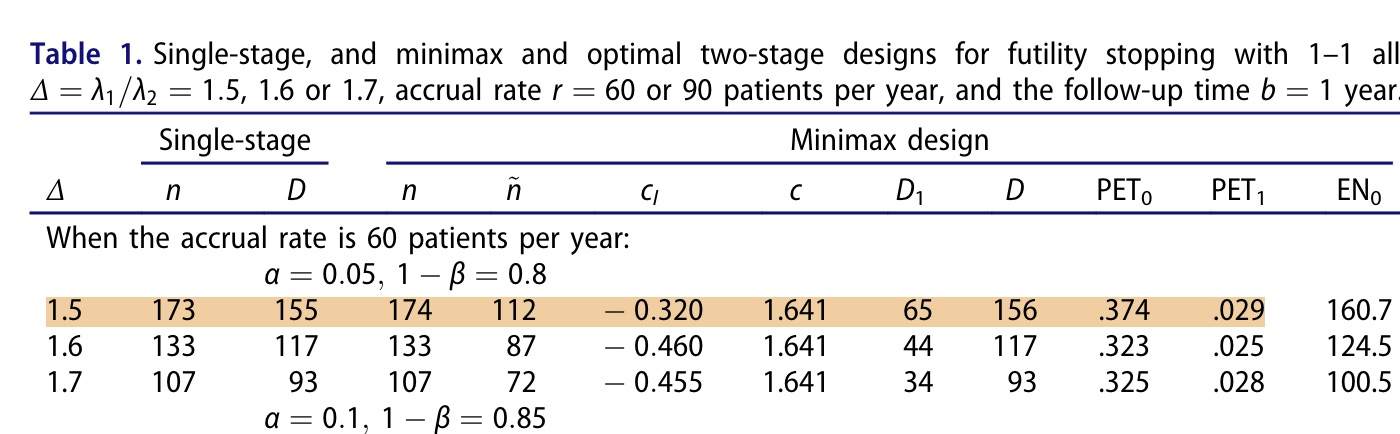

In [ ]:
display_jpeg(file='figures/Jung(2017)_table_1.jpeg')

#### Under PH, we can find a proper critical value to make 2 stages power ~ single stage 
#### This conclusion is true when stopping for both superiority and futility or for futility only.
#### overall $\textcolor{lightgreen}{\alpha = P(\frac{W_1}{\sigma_1}>C_u|H_0) + P(C_l<\frac{W_1}{\sigma_1}<C_u,\frac{W}{\sigma}>C|H_0)}$
-------

# Our Rejection Region
### <span style="color:yellow">E and C are the RMST value of experiment group and control group respectively
### subscript 1 means interim period, 2 for final period
#### Stage I : process to stage II (reject $H_0$) when:  
####  $\textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_1) > t_1}$, where $m_1>0$
### Stage II:
#### reject $H_0$ when:  
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2},\ $  $m_1, m_2 >0$


### By the asymptotic normality of RMST:
$$
 \textcolor{lightgreen}{[E1-C1,\ E1,\ E2-C2,\ E2] \sim \mathcal{N}\ (\ \hat{\mu},\ \hat{\Sigma}\ )}
$$

$$
\hat{\Sigma} = 
 \left[
 \begin{matrix}
   Var(E1)+Var(C1) & Var(E1) & Cov(E1,E2)+Cov(C1,C2) & Cov(E1,E2) \\
                   & Var(E1) & Cov(E1,E2) & Cov(E1,E2) \\
                   &         & Var(E2)+Var(C2) & Var(E2)\\
                   &         &                 & Var(E2)\\
  \end{matrix}
\right]
$$

## Monte Carlo
$ var[\widehat{RMST_{E1}}]=\frac{1}{B}\sum\limits_{i = 1}^{B} (\widehat{RMST_{E1,i}} - \bar{RMST_{E1}})^2$

Similar to Lu(2021) 

$$
 \left[
 \begin{matrix}
   Var(\hat{E1}) & Cov(\hat{E1}, \hat{E2}) \\
   Cov(\hat{E1}, \hat{E2}) & Var{\hat{E2}} \\
  \end{matrix}
  \right] = 

\frac{1}{B}\sum\limits_{i = 1}^{B} 
 \left[
 \begin{matrix}
   \widehat{RMST_{E1}} - \bar{RMST_{E1}} \\
   \widehat{RMST_{E2}} - \bar{RMST_{E2}} \\
  \end{matrix}
  \right] ^{\bigotimes2}_i 
$$

$ \bar{RMST_{E1}} = \frac{1}{B}\sum^{B}_{i = 1}RMST_{E1,i}$ is the mean RMST value of simulation
#### <span style="color:yellow">Use the setting of Jung 2017 table 1 first row (Minimax)




In [3]:
set.seed(2024)
sim_size <- 10000 
N <- 200
r <- 100
acc_time <- N / r
cen_time <- 1
lambda_H0 <- 1.2
HR <- 0.7
lambda_H1 <- 1.2 * HR
change_time <- 1
interim <- 1.4
n <- ceiling(N / 2)
alpha <- 0.05

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
                                
rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)                                 
rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

# Under H0
mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
# Under H1
mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)

# log-rank data
lr_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
lr_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
lr_h0_fin <- log_rank_sim(data_C = data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
lr_h1_fin <- log_rank_sim(data_C = data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
# Get W/sigma
z_stats_h1_int <- lr_h1_int$z_stats
z_stats_h1_fin <- lr_h1_fin$z_stats
z_stats_h0_int <- lr_h0_int$z_stats
z_stats_h0_fin <- lr_h0_fin$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin) 
# corr(W1, W | H0)
corr_h0 <- sqrt(mean(lr_h0_int$var_w) / mean(lr_h0_fin$var_w))         


### The RMST normality under $H_0$ and $H_1$ at interim

Warning message:
“Removed 4 rows containing non-finite outside the scale range
(`stat_density2d()`).”
Warning message:
“Removed 5 rows containing non-finite outside the scale range
(`stat_density2d()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range
(`stat_density2d()`).”


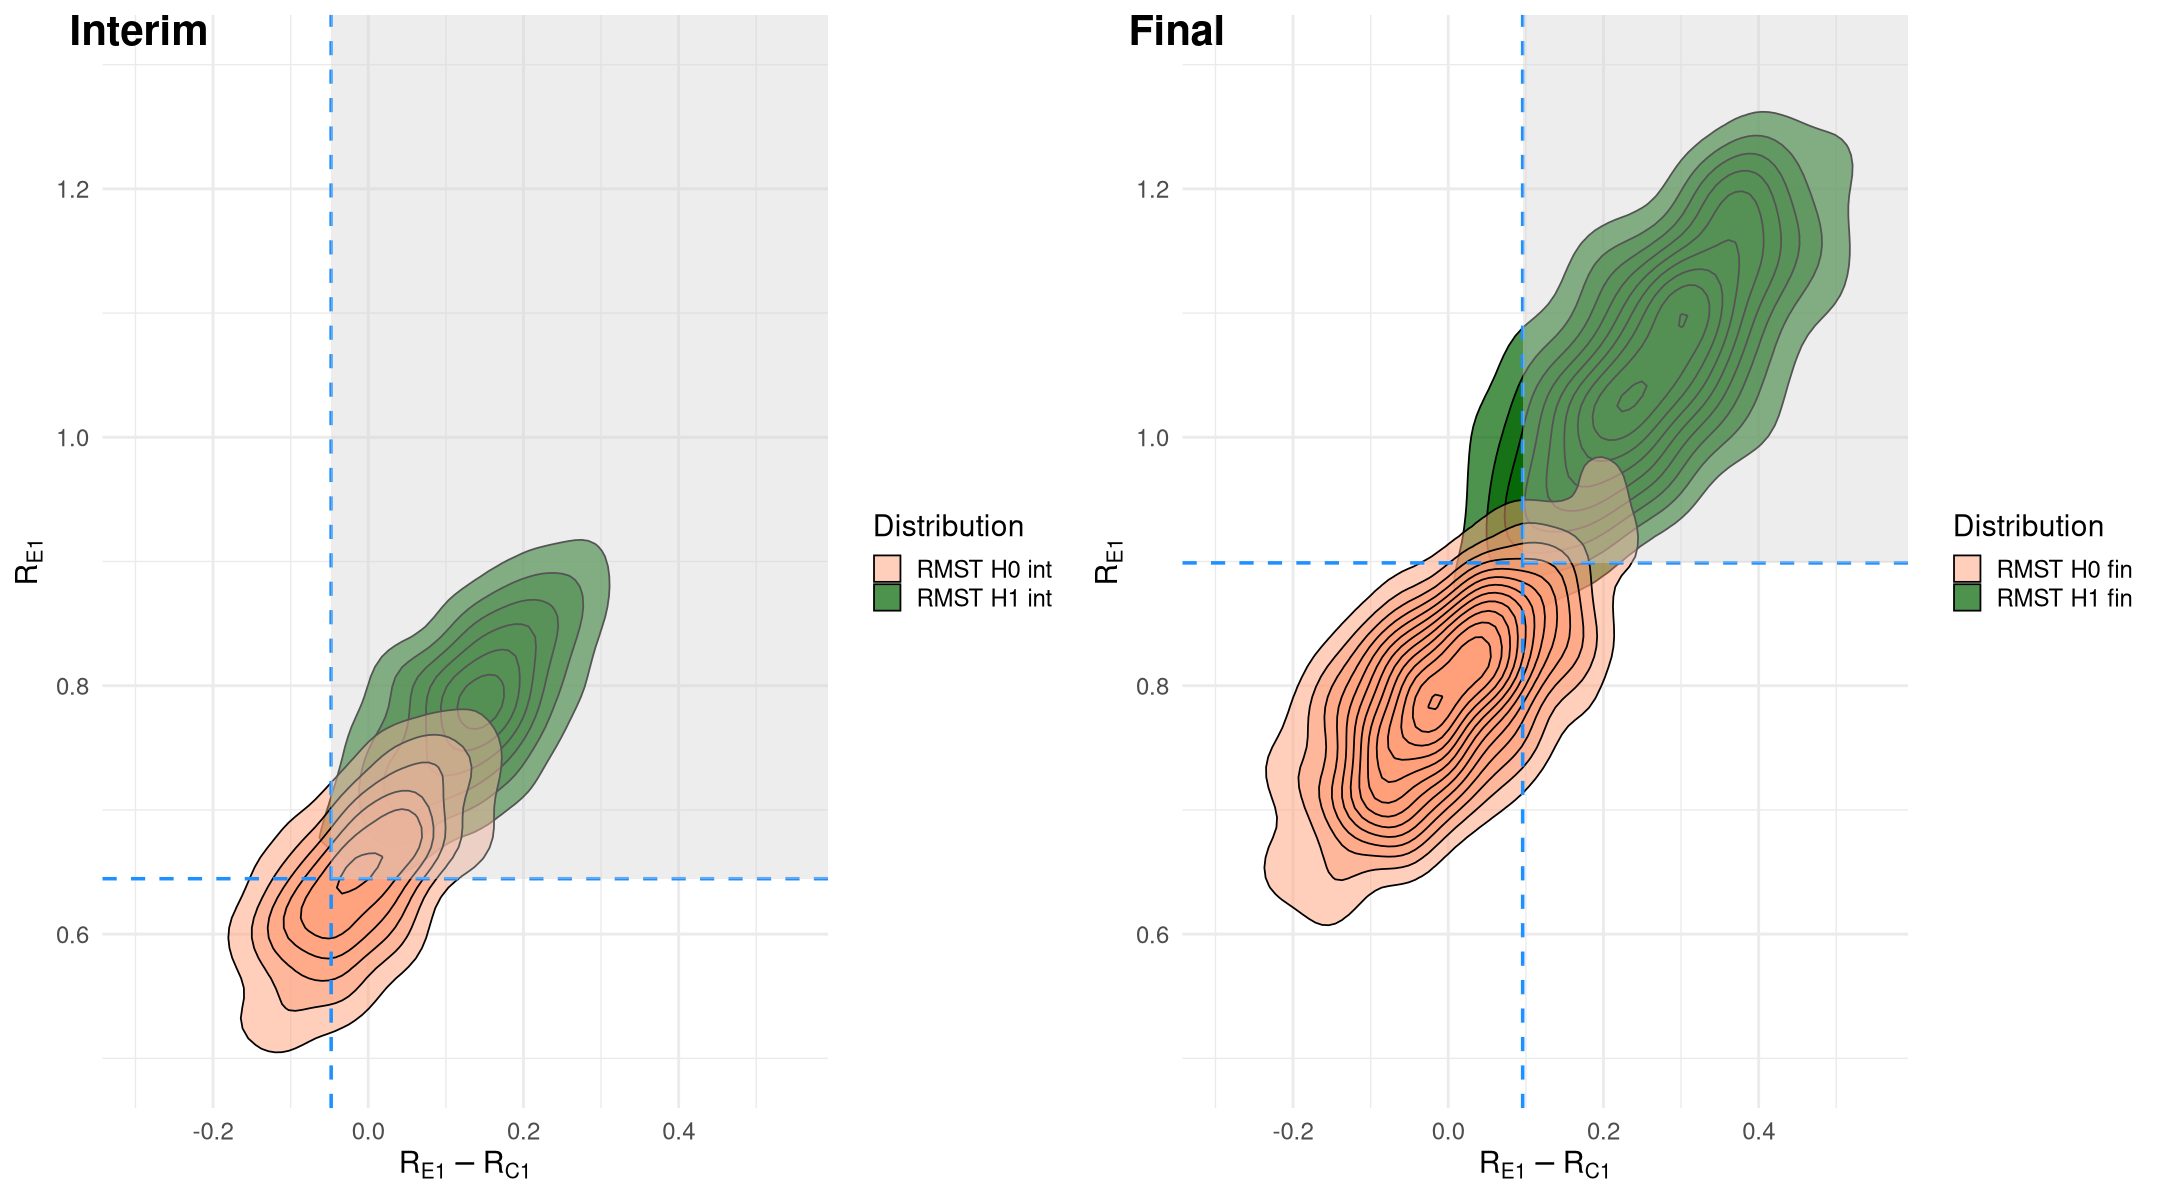

In [6]:
set.seed(2024)
# H0 interm
mu0_i<- mu_cov_h0$mu[c(1,2)]
sigma0_i <- mu_cov_h0$sigma[1:2, 1:2]
#H1 interim 
mu1_i <- mu_cov_h1$mu[c(1,2)]
sigma1_i <- mu_cov_h1$sigma[1:2, 1:2]

# H0 final
mu0_f <- mu_cov_h0$mu[c(3,4)]
sigma0_f <- mu_cov_h0$sigma[3:4, 3:4]
#H1 final 
mu1_f <- mu_cov_h1$mu[c(3,4)]
sigma1_f <- mu_cov_h1$sigma[3:4, 3:4]

data0_i <- mvrnorm(500, mu = mu0_i, Sigma = sigma0_i)
data1_i <- mvrnorm(500, mu = mu1_i, Sigma = sigma1_i)
df0_i <- data.frame(x = data0_i[,1], y = data0_i[,2], group = "RMST H0 int")
df1_i <- data.frame(x = data1_i[,1], y = data1_i[,2], group = "RMST H1 int")

data0_f <- mvrnorm(500, mu = mu0_f, Sigma = sigma0_f)
data1_f <- mvrnorm(500, mu = mu1_f, Sigma = sigma1_f)
df0_f <- data.frame(x = data0_f[,1], y = data0_f[,2], group = "RMST H0 fin")
df1_f <- data.frame(x = data1_f[,1], y = data1_f[,2], group = "RMST H1 fin")

x_i <- as.numeric(best_our$m1)
y_i <- as.numeric(best_our$q1)

df1_i <- df1_i[is.finite(df1_i$x) & is.finite(df1_i$y), ]
df0_i <- df0_i[is.finite(df0_i$x) & is.finite(df0_i$y), ]

plot1 <- ggplot() +
     stat_density_2d(data = df1_i, aes(x = x, y = y, fill = "RMST H1 int"), geom = "polygon", alpha = 0.7, color = "black") +
     stat_density_2d(data = df0_i, aes(x = x, y = y, fill = "RMST H0 int"), geom = "polygon", alpha = 0.5, color = "black") +
     scale_fill_manual(values = c("RMST H0 int" = "#FFA07A",  
                               "RMST H1 int" = "#006400")) +  
     theme_minimal(base_size = 18) +
     xlim(-0.3,0.55) +
     ylim(0.5,1.3) +
     geom_hline(aes(yintercept = y_i), color = "#1E90FF", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
     geom_vline(aes(xintercept = x_i), color = "#1E90FF", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
     annotate("rect", xmin = x_i, xmax = Inf, ymin = y_i, ymax = Inf, fill = "lightgrey", alpha = 0.4) +
    
     labs(
       x = expression(R[E1]-R[C1]),
       y = expression(R[E1]),
       fill = "Distribution") +
     theme(legend.position = "right")

x_f <- as.numeric(best_our$m2)
y_f <- as.numeric(best_our$q2)
df1_f <- df1_f[is.finite(df1_f$x) & is.finite(df1_f$y), ]
df0_f <- df0_f[is.finite(df0_f$x) & is.finite(df0_f$y), ]
plot2 <- ggplot() +
     stat_density_2d(data = df1_f, aes(x = x, y = y, fill = "RMST H1 fin"), 
                    geom = "polygon", alpha = 0.7, color = "black") +
     stat_density_2d(data = df0_f, aes(x = x, y = y, fill = "RMST H0 fin"), 
                    geom = "polygon", alpha = 0.5, color = "black") +
     scale_fill_manual(values = c("RMST H0 fin" = "#FFA07A",  
                               "RMST H1 fin" = "#006400")) +  
     theme_minimal(base_size = 18) +
     xlim(-0.3,0.55) +
     ylim(0.5,1.3) +
     geom_hline(aes(yintercept = y_f), color = "#1E90FF", linewidth = 1, 
                    linetype = "dashed", show.legend = FALSE) +
     geom_vline(aes(xintercept = x_f), color = "#1E90FF", linewidth = 1, 
                    linetype = "dashed", show.legend = FALSE) +
     annotate("rect", xmin = x_f, xmax = Inf, ymin = y_f, ymax = Inf, fill = "lightgrey", alpha = 0.4) +
     labs(
       x = expression(R[E1]-R[C1]),
       y = expression(R[E1]),
       fill = "Distribution") +
     theme(legend.position = "right")

options(repr.plot.width = 18, repr.plot.height = 10)
combined_plot <- plot_grid(plot1, plot2, labels = c("Interim", "Final"), label_size = 25, ncol = 2)
ggsave("figures/2-d-normal-projection.jpg", plot = combined_plot, width = 18, height = 9, dpi = 600)
combined_plot

______________
# <span style="color:yellow">  Parameter Optimization (Grid Search)
Reference: Zhou(2017) BOP2 Bayesian design. DOI:10.1002/sim.7338

#### In order to solve the critical values ($m_1,\ q_1,\ m_2,\ q_2$), a function that can control the normal probability is required. The following $\mathcal{f}(n)$  is what we proposed.
$$
\large \mathcal{f}(n) = \mathcal{e}^{-\ \gamma · \frac{n}{N}},\ \gamma>0
$$
#### $ \mathcal{f}(n)$ is a monotonously decereasing funciton of n, which means that two probability constraints in interim period will go up when the interim sample size n decrease. <span style="color:yellow"> It leads to a small early stop probability with an insufficient interim sample size. $n$ is the sample size(2 arms) of interim period. $N$ is the final total sample size of 2 arms. 
$$
D_i = E_i - C_i
$$
#### Then we set the following constraints:
$$
\begin{aligned}
\large P(E_1 > q_1\ |\ D_1 > m_1) &=  \mathcal{f}(n) \\
\large P(E_2 > q_2\ |\ D_2 > m_2) &=  \mathcal{f}(N) \\
\end{aligned}
$$

### Search (m,q) stage by stage. Given a threshold prob under H1
$$
\large P (E_i > q_i\ |\ D_i > m_i | H_1) = p_i
$$
### Make use of the normality of conditional distribution, $\rho$ is the correlation.
$$
E_1 | D_1\ \sim N(\mu, \sigma) \\
\\
\mu = (\mu_{E1} + \rho \cdot \sigma_{E1}/\sigma_{D1} \cdot (D_1 - \mu_{D1}))\\
\\
\Sigma = \sigma_{E1}^2 \cdot (1 - \rho^2)\\
$$

#### Then we grid search $(\lambda, \gamma)$ . Each pair of $(\lambda, \gamma)$ determines a set of ($m_1,\ q_1,\ m_2,\ q_2$) by normal calculation. Record critical values sets that yield the desirable overall type I error $\alpha$:
$$
\large P(D_1>m_1\ \&\  E_1>q_1\ \&\  D_2>m_2\ \&\  E_2>q_2\ |H_0) < \alpha
$$
#### Find the most powerful one under $H_1$ among these ($m_1,\ q_1,\ m_2,\ q_2$)

#### <span style="color:yellow"> Remark: for single stage design, we only search under the last two constraints.
#### * The grid searching procedure above is packed in function: 'adp_grid_src'

In [5]:
set.seed(2024)
best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                int_n = interim * r, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size, method = 'Complex')
best_our

,m1,m2,q1,q2,gamma,PET0,PET1,alpha,power
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4041,-0.04782399,0.0958868,0.6446217,0.8988594,0.04,0.5393,0.0447,0.0488,0.8873


### Use the normality of 4d RMST to calculate the Type I error and Power
### * The alpha and power calculated in the function above is based on the simulated survival data

In [30]:
threshold <- as.numeric(best_our[1:4])
# Monte Carlo normal probability 
norm_sam_h0 <- mvrnorm(100000, mu = mu_cov_h0$mu, Sigma = mu_cov_h0$sigma)
norm_sam_h1 <- mvrnorm(100000, mu = mu_cov_h1$mu, Sigma = mu_cov_h1$sigma)

cat('The type one error is:',sum(apply(norm_sam_h0, 1, function(x) all(x > threshold))) / 100000, '\n')
cat('The Power is:',sum(apply(norm_sam_h1, 1, function(x) all(x > threshold))) / 100000, '\n')

The type one error is: 0.04907 
The Power is: 0.7802 


### <span style="color:yellow">  The power is slightly higher than LR but cost should be global robustness (Litwin 2017)  
------


## Global Robustness
#### Litwin mentioned that when the real distribution parameters vary from the stated ones, the alpha under the same critical values will increase sharply. This method will sacrify globally robustness.
### <span style="color:yellow"> Compare the robustness between LR test and Our method when Hazard Ratio change
#### $\lambda_E| H_1 = 0.9,\ \frac{\lambda_E}{\lambda_C} = 0.67$ Follow Jung 2017 table1

In [7]:
best_lr <- find_m_logrank(logrank_data = logrank_data, search_times = 500, corr_h0 = corr_h0,
                 alpha = alpha, sim_size = sim_size)
best_rmst <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                int_n = interim * r, fin_n = 2 * n, alpha = alpha, sim_size = sim_size, method = 'Simple')
best_lr
best_rmst

m1,m2,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.6779285,1.641859,0.255,0.0188,0.0476,0.7407


,m1,m2,PET0,PET1,alpha,power
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5969,-0.02759407,0.1669907,0.3835,0.0468,0.0499,0.7842


### Mimic the situation that $\lambda_1$ is precise but real $\lambda_0$ deviates from the stated one
#### <span style="color:yellow"> Use the same critical values calculated when $\lambda_0 = 1.2, \lambda_1 = 0.84$
#### $H0: \lambda_E = \lambda_C = \lambda_0$
#### $H1: \lambda_C =  \lambda_0,\ \lambda_E =  \lambda_1$

In [10]:
m1 <- as.numeric(best_our$m1)
q1 <- as.numeric(best_our$q1)
m2 <- as.numeric(best_our$m2)
q2 <- as.numeric(best_our$q2)

# Critical value of LR and simple RMST
m1_lr <- best_lr$m1
m2_lr <- best_lr$m2
m1_rmst <- best_rmst$m1
m2_rmst <- best_rmst$m2

lambda_H0 <- 1.2
#lambda_H1 <- 1.2 * 0.7  #0.84
diff_HR_robust <- foreach(lambda_H1 = seq(0.6, 1, by = 0.04), .combine = rbind) %dopar%
{
    data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 0, interim = interim)    
    data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
    data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim) 

    rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)                        
    rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)

    z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats

    a_lr <- sum(z_stats_h0_int > m1_lr & z_stats_h0_fin > m2_lr) / sim_size
    power_lr <- sum(z_stats_h1_int > m1_lr & z_stats_h1_fin > m2_lr) / sim_size
    pet0_lr <- sum(z_stats_h0_int <= m1_lr) / sim_size
    pet1_lr <- sum(z_stats_h1_int <= m1_lr) / sim_size

    a_rmst <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1_rmst) &
                    (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2_rmst)) / sim_size
    power_rmst <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1_rmst) &
                    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2_rmst)) / sim_size
    pet0_rmst <- sum(rmst_h0_int[2, ] - rmst_h0_int[1, ] <= m1_rmst) / sim_size
    pet1_rmst <- sum(rmst_h1_int[2, ] - rmst_h1_int[1, ] <= m1_rmst) / sim_size

    a_our <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1) & (rmst_h0_int[2, ] > q1) &
                (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2) & (rmst_h0_fin[2, ] > q2)) / sim_size
    power_our <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1) & (rmst_h1_int[2, ] > q1) &
                    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2) & (rmst_h1_fin[2, ] > q2)) / sim_size
    pet0_our <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] <= m1) | (rmst_h0_int[2, ] <= q1)) / sim_size
    pet1_our <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] <= m1) | (rmst_h1_int[2, ] <= q1)) / sim_size
   
    return(c(lambda_H1, a_lr, a_rmst, a_our, power_lr, power_rmst, power_our, 
            pet0_lr, pet0_rmst, pet0_our, pet1_lr, pet1_rmst, pet1_our ))
}

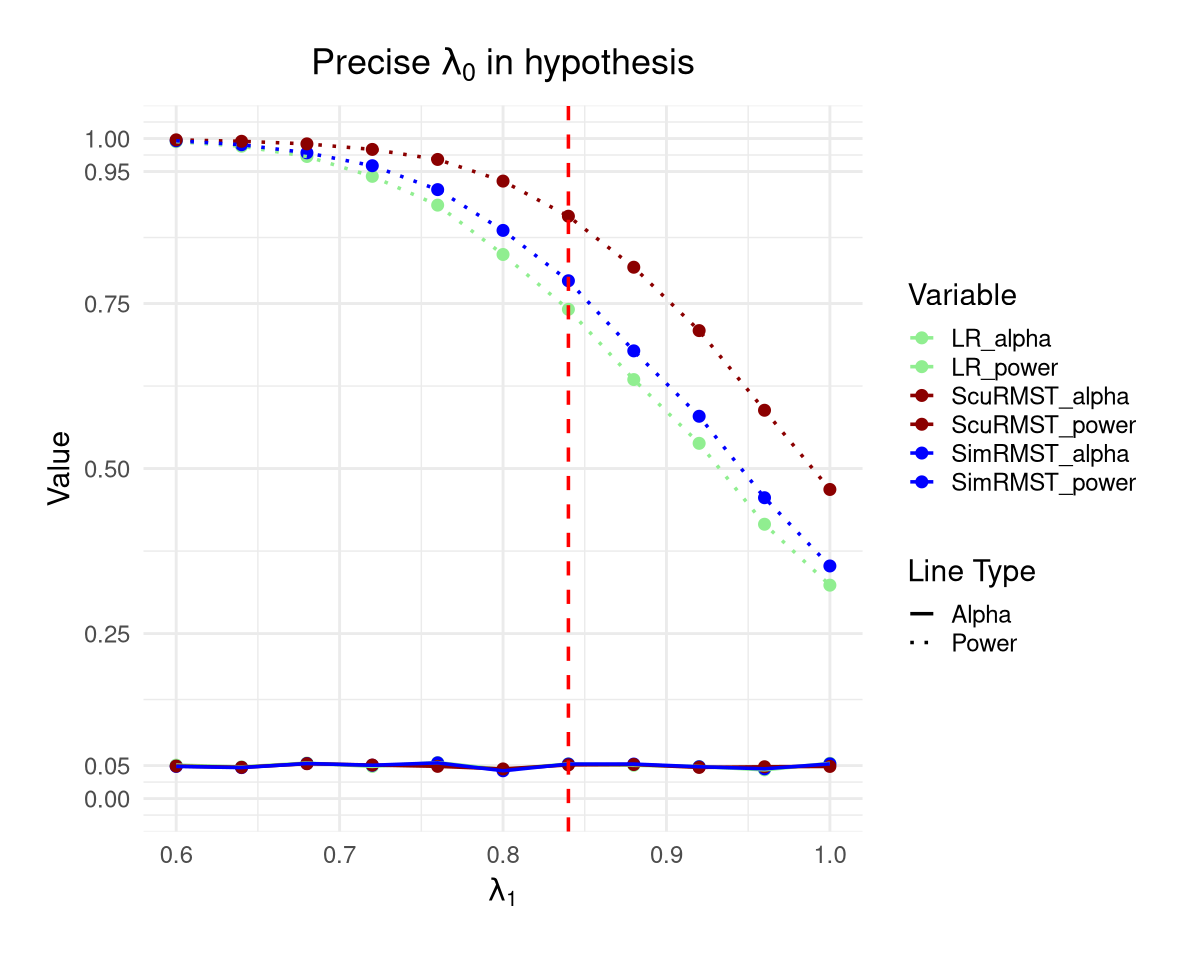

In [11]:
options(repr.plot.width = 10, repr.plot.height = 8)
data <- diff_HR_robust
    color_palette <- c("ScuRMST_power" = "darkred", "ScuRMST_alpha" = "darkred", 
                      "LR_power" = "lightgreen", "LR_alpha" = "lightgreen",
                      "SimRMST_power" = "blue", "SimRMST_alpha" = "blue",
                      "ScuRMST_PET0" = "darkred", "ScuRMST_PET1" = "darkred", 
                      "LR_PET0" = "lightgreen", "LR_PET1" = "lightgreen",
                      "SimRMST_PET0" = "blue", "SimRMST_PET1" = "blue")

    a_power_delta <- data.frame(data[, c(1,2,3,4,5,6,7)])
    colnames(a_power_delta) <- c('lambda_1','LR_alpha','SimRMST_alpha','ScuRMST_alpha',
                          'LR_power', 'SimRMST_power','ScuRMST_power')
    a_power_long <- a_power_delta %>%
        pivot_longer(cols = -!!sym('lambda_1'), names_to = "variable", values_to = "value")%>%
        mutate(linetype_group = ifelse(variable %in% 
            c("LR_alpha", "SimRMST_alpha", "ScuRMST_alpha"), "Alpha", "Power"))
    a_power_long <- a_power_long %>% filter(value != 0)   # 0 means could not find critical values

p_HR2 <- ggplot(a_power_long, aes(x = !!sym('lambda_1'), y = value, 
        color = variable, linetype = linetype_group)) +
    geom_point(size = 3) +
    geom_line(linewidth = 1) +
    geom_vline(xintercept = 0.84, color = "red", linetype = "dashed", linewidth = 1) +
    scale_linetype_manual(values = c("Alpha" = "solid", "Power" = "dotted")) +
    labs( linetype = "Line Type", color = "Variable",
          title = "Line Plot with Different Line Types") +
    scale_y_continuous(breaks = c(0, 0.05, 0.25, 0.5, 0.75, 0.95, 1), limits = c(0, 1)) +
    scale_color_manual(values = color_palette) +
    labs(x = expression(lambda[1]), y = "Value", color = "Variable",
      title = expression(paste("Precise ",lambda[0]," in hypothesis"))) +
    theme_minimal(base_size = 18) + 
    theme(plot.title = element_text(hjust = 0.5),
          plot.background = element_rect(fill = "white", color = NA),
          plot.margin = unit(c(1, 1, 1, 1), "cm")) +
    guides(linetype = guide_legend(override.aes = list(color = "black")),
        color = guide_legend(override.aes = list(linetype = "solid")))
p_HR2


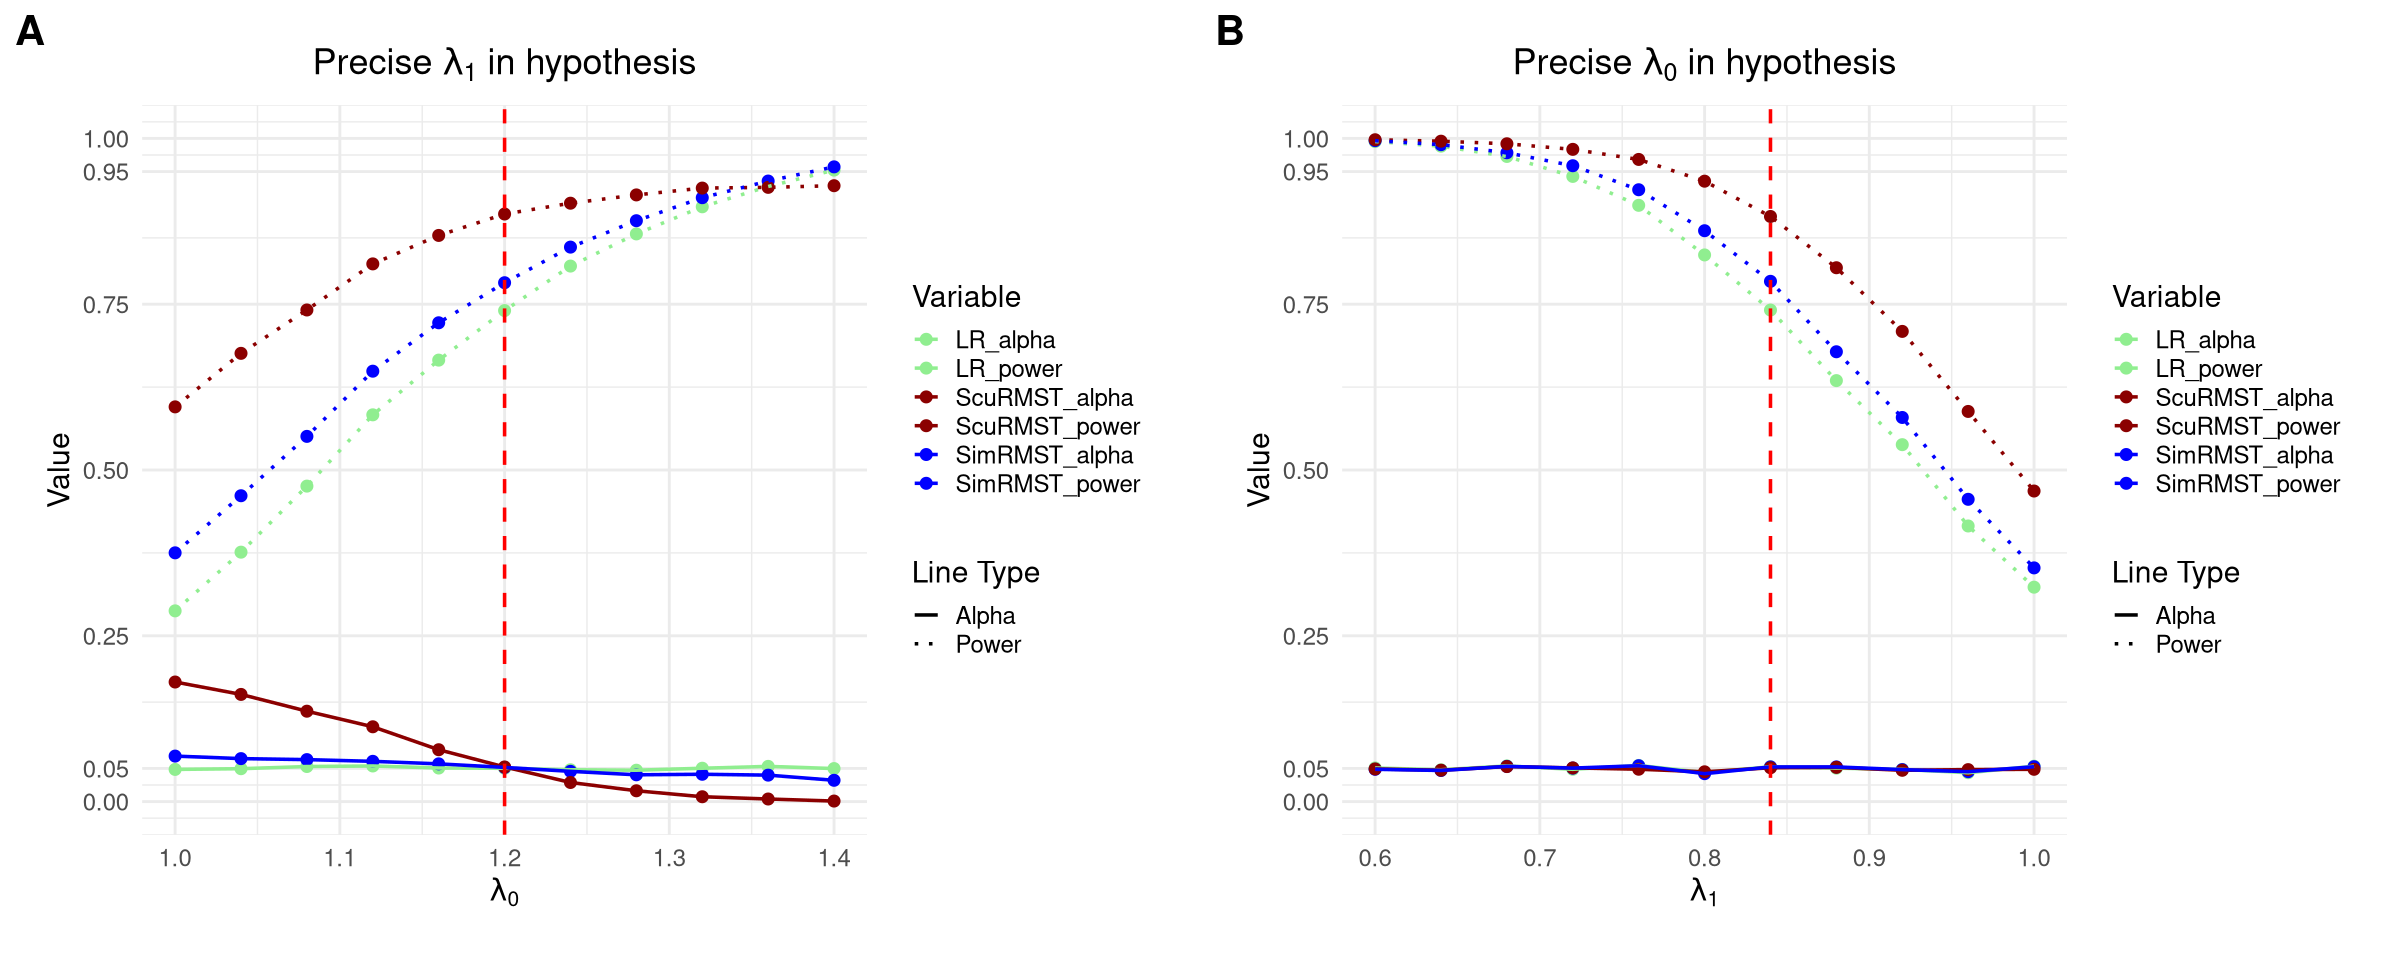

In [12]:
options(repr.plot.width = 20, repr.plot.height = 8)
combined_plot <- plot_grid(p_HR1, p_HR2, labels = c("A", "B"), label_size = 25, ncol = 2)
ggsave("figures/Robustness.jpg", plot = combined_plot, width = 18, height = 9, dpi = 600)
combined_plot

-------

## Visualization of critical regions

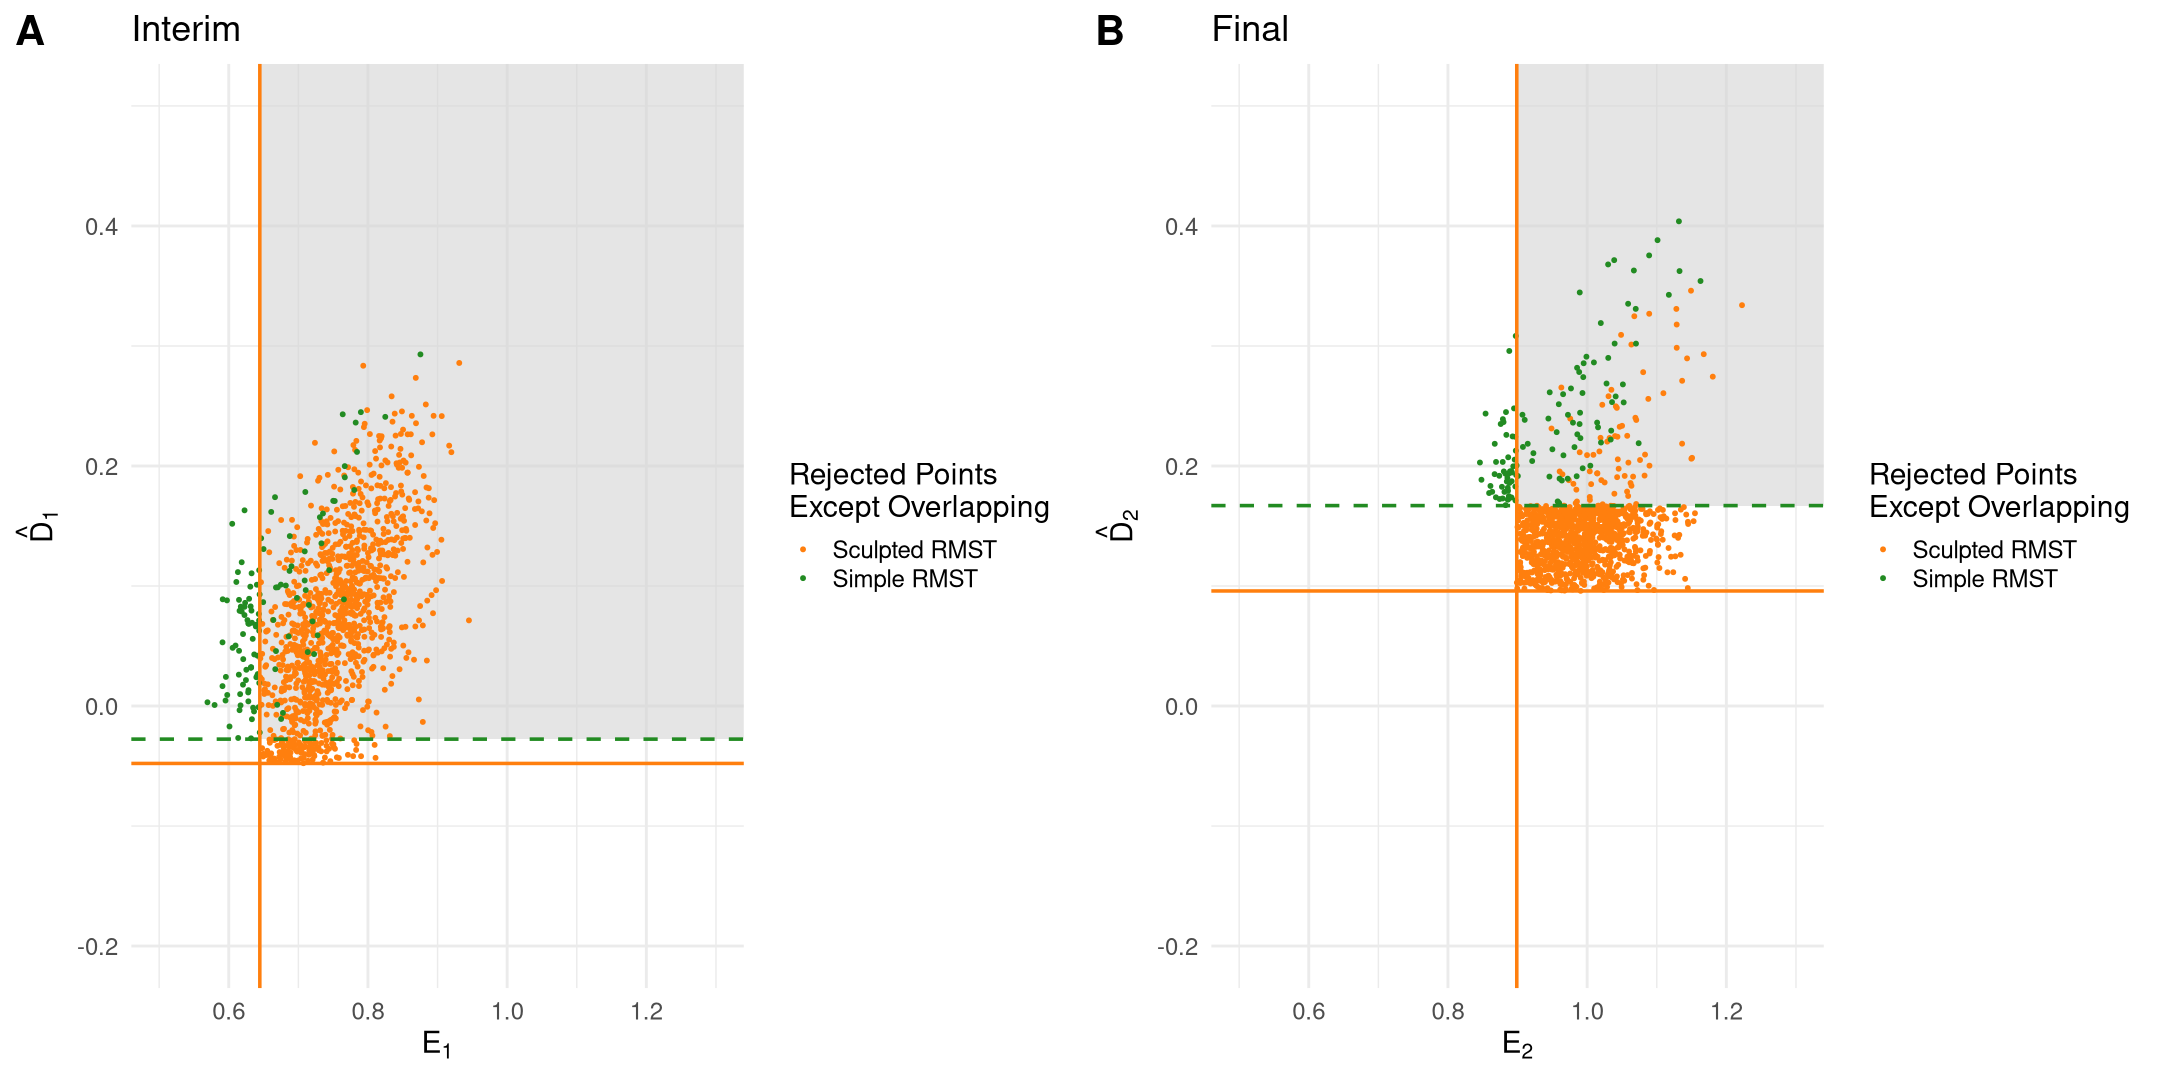

In [18]:
m1 <- as.numeric(best_our$m1)
q1 <- as.numeric(best_our$q1)
m2 <- as.numeric(best_our$m2)
q2 <- as.numeric(best_our$q2)
m1_rmst <- best_rmst$m1
m2_rmst <- best_rmst$m2

rmst_data <- rbind(rmst_h1_int, rmst_h1_fin)
D1 <- rmst_data[2,] - rmst_data[1,]
R1 <- rmst_data[2,]
D2 <- rmst_data[4,] - rmst_data[3,]
R2 <- rmst_data[4,]
# Rejection region
Scu_R <- as.matrix(rmst_data[, which(D1 > m1 & R1 > q1 & D2 > m2 & R2 > q2)])
Sim_R <- as.matrix(rmst_data[, which(D1 > m1_rmst & D2 > m2_rmst)])

# Prepare data for the first scatterplot
data1 <- data.frame(
  x = c(Scu_R[2, ], Sim_R[2, ]),
  y = c(Scu_R[2, ] - Scu_R[1, ], Sim_R[2, ] - Sim_R[1, ]),
  group = rep(c("Sculpted RMST", "Simple RMST"), times = c(ncol(Scu_R), ncol(Sim_R)))
)
data1 <- data1 %>%
  group_by(x, y) %>%
  mutate(overlap = ifelse(n() > 1, "Overlap", group)) %>%
  ungroup()

data1 <- data1[data1$overlap != 'Overlap' , ]
plot1 <- ggplot(data1, aes(x = x, y = y, color = overlap)) +
  annotate("rect", xmin = q1, xmax = Inf, ymin = m1_rmst, ymax = Inf, fill = "lightgrey", alpha = 0.6) +
  geom_point(size = 1) +
  scale_color_manual(values = c("Simple RMST" = "#228B22", "Sculpted RMST" = "#ff7f0e")) +
  labs(title = "Interim", 
      x = expression(E[1]), 
      y = expression(hat(D)[1]), 
      color = "Rejected Points\nExcept Overlapping") +
  theme_minimal(base_size = 18) +
  xlim(0.5, 1.3) +
  ylim(-0.2, 0.5)+
  geom_hline(aes(yintercept = m1_rmst), color = "#228B22", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
  geom_hline(aes(yintercept = m1), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) +
  geom_vline(aes(xintercept = q1), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) 
  

# Prepare data for the second scatterplot
data2 <- data.frame(
  x = c(Scu_R[4, ], Sim_R[4, ]),
  y = c(Scu_R[4, ] - Scu_R[3, ], Sim_R[4, ] - Sim_R[3, ]),
  group = rep(c("Sculpted RMST", "Simple RMST"), times = c(ncol(Scu_R), ncol(Sim_R)))
)
data2 <- data2 %>%
  group_by(x, y) %>%
  mutate(overlap = ifelse(n() > 1, "Overlap", group)) %>%
  ungroup()

data2 <- data2[data2$overlap != 'Overlap' , ]
plot2 <- ggplot(data2, aes(x = x, y = y, color = overlap)) +
  annotate("rect", xmin = q2, xmax = Inf, ymin = m2_rmst, ymax = Inf, fill = "lightgrey", alpha = 0.6) +
  geom_point(size = 1) +
  scale_color_manual(values = c("Simple RMST" = "#228B22", "Sculpted RMST" = "#ff7f0e")) +
  labs(title = "Final", 
      x = expression(E[2]), 
      y = expression(hat(D)[2]), 
      color = "Rejected Points\nExcept Overlapping") +
  theme_minimal(base_size = 18) +
  xlim(0.5, 1.3) +
  ylim(-0.2, 0.5)+
  geom_hline(aes(yintercept = m2_rmst), color = "#228B22", linewidth = 1, linetype = "dashed", show.legend = FALSE) +
  geom_hline(aes(yintercept = m2), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE) +
  geom_vline(aes(xintercept = q2), color = "#ff7f0e", linewidth = 1, linetype = "solid", show.legend = FALSE)


options(repr.plot.width = 18, repr.plot.height = 9)
combined_plot <- plot_grid(plot1, plot2, labels = c("A", "B"), label_size = 25, ncol = 2)
ggsave("figures/rejection_plot.jpg", plot = combined_plot, width = 18, height = 9, dpi = 600)
combined_plot

### 245 green dots, 132 orange and 253 blue

In [110]:
# Blue dots outside of shaded region interim
dim(data1[data1$overlap != 'Overlap' & data1$group == 'Simple RMST' & data1$x<t1, ])
# orange dots outside of shaded region interim
dim(data1[data1$overlap != 'Overlap' & data1$group == 'Sculpted RMST' & data1$y<m1_rmst, ])

# Blue dots out of shaded region final
dim(data2[data2$overlap != 'Overlap' & data2$group == 'Simple RMST' & data2$x < t2, ])
# orange dots out of shaded region final
dim(data2[data2$overlap != 'Overlap' & data2$group == 'Sculpted RMST' & data2$y < m2_rmst, ])

[1] 55  4

[1] 22  4

[1] 240   4

[1] 121   4

####  Blue dots on the left lateral region of the shaded region increase by 240-55 = 185 from interm to final  
####  Orange dots below the shaded region increase by 121-22 = 99 from interm to final 
---- 